## **ESTABLECIMIENTO DEL DATASET**

Para este clasificador de señales LoRa según su Spreading Factor, se toma como base el dataset que se ha creado en el cuaderno [Generador de Dataset](https://colab.research.google.com/drive/1G8r4KLLBJAZ0tv9yxPX4-g9NP4xhShuV?usp=sharing). Para utilizarlo en este cuaderno, es necesario contar con el acceso al archivo PKL, que en este caso se encuentra en Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se prepara el entorno para construir y entrenar modelos de deep learning, específicamente redes neuronales convolucionales (CNN). Para ello, se importan librerías comunes de machine learning, así como las herramientas para crear y entrenar los modelos de deep learning.

In [ ]:
%matplotlib inline
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import joblib  # For saving and loading model
import time

Se procede a cargar los datos del archivo PKL que contiene el dataset, para realizar:



*   Extracción de valores de SNR, y de las etiquetas presentes en el diccionario.
*   Se iteran estas combinaciones únicas para construir matrices de caracteríticas (X) y vectores de etquetas (lbl), apilando todos los datos disponibles para cada combinación SNR/Spreading Factor.
*   Se concatena todo en matrices Numpy únicas (X) y (lbl), que contienen todas las muestras disponibles, con sus correspondientes etiquetas.


In [ ]:
Xd = pickle.load(open("/content/drive/MyDrive/Datasets/LoRa/dataset2-1024-sf7-al-12.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

Se imprimen algunas variables para conocer las características extraídas del dataset, como los valores de SNR obtenidos, las etiquetas encontradas, los bloques dentro de una clave especificada, etc...

In [ ]:
print(snrs)
print(mods)

[38]
[b'SF07', b'SF08', b'SF09', b'SF10', b'SF11', b'SF12']


In [ ]:
print(Xd[(b'SF07', 38)].shape)

(27588, 2, 1024)


In [ ]:
print(X)

[[[-0.0012207  -0.0022583  -0.00054932 ...  0.003479    0.00302124
    0.00241089]
  [-0.00234985 -0.0017395  -0.00250244 ...  0.00985718  0.0093689
    0.00875854]]

 [[ 0.00338745  0.00405884  0.00476074 ...  0.04263306  0.04199219
    0.04187012]
  [ 0.00878906  0.00814819  0.00842285 ... -0.00668335 -0.00784302
   -0.00830078]]

 [[ 0.04248047  0.04168701  0.04165649 ... -0.01226807 -0.01330566
   -0.01376343]
  [-0.00860596 -0.00888062 -0.00918579 ... -0.06484985 -0.06451416
   -0.06427002]]

 ...

 [[-0.06390381 -0.06826782 -0.06973267 ...  0.00518799  0.02084351
    0.03561401]
  [ 0.0267334   0.01278687 -0.00024414 ... -0.06991577 -0.06558228
   -0.05895996]]

 [[ 0.04898071  0.05743408  0.06414795 ...  0.02560425  0.00787354
   -0.0111084 ]
  [-0.04980469 -0.03729248 -0.02444458 ...  0.06582642  0.06939697
    0.06872559]]

 [[-0.02734375 -0.04107666 -0.05514526 ... -0.05148315 -0.03634644
   -0.01922607]
  [ 0.06466675  0.05499268  0.04257202 ... -0.04879761 -0.05950928
   -0

(OPCIONAL) Se puede leer el archivo PKL para verificar que coincida con lo creado en el dataset.

In [ ]:
import pickle
import numpy as np
import codecs

with open('/content/drive/MyDrive/Datasets/LoRa/dataset2-1024-sf7-al-12-tw.pkl','rb') as f:
  data = pickle.load(f, encoding='bytes')

print(data)
print(type(data))

{(b'SF12', 38): array([[[-0.06021118, -0.06524658, -0.06863403, ...,  0.0630188 ,
          0.05532837,  0.04553223],
        [ 0.03381348,  0.02182007,  0.00994873, ...,  0.03015137,
          0.04269409,  0.05282593]],

       [[ 0.03387451,  0.02108765,  0.00747681, ...,  0.02175903,
          0.0368042 ,  0.04940796],
        [ 0.06143188,  0.06637573,  0.0692749 , ..., -0.06530762,
         -0.05895996, -0.04751587]],

       [[ 0.05932617,  0.0652771 ,  0.0692749 , ..., -0.06774902,
         -0.06085205, -0.05041504],
        [-0.03497314, -0.02139282, -0.00531006, ..., -0.01776123,
         -0.03488159, -0.05004883]],

       ...,

       [[-0.06390381, -0.06826782, -0.06973267, ...,  0.00518799,
          0.02084351,  0.03561401],
        [ 0.0267334 ,  0.01278687, -0.00024414, ..., -0.06991577,
         -0.06558228, -0.05895996]],

       [[ 0.04898071,  0.05743408,  0.06414795, ...,  0.02560425,
          0.00787354, -0.0111084 ],
        [-0.04980469, -0.03729248, -0.0244445

## **CONJUNTOS DE ENTRENAMIENTO Y PRUEBAS**

A continuación, se particionan los datos X previamente preparados en conjuntos de entrenamiento (train) y prueba (test) para poder entrenar y evaluar el modelo a configurar más adelante.

*   Se establece una semilla aleatoria para asegurar reproducibilidad.
*   Se calcula el número total de ejemplos/muestras en X.
*   Se define el tamaño del conjunto de entrenamiento a un 70% del total de los datos.
*   Se seleccionan aleatoriamente los índices que formarán parte del conjunto de entrenamiento.
*   El conjunto de prueba se calcula como los indices restantes.
*   Se indexa la matriz X para obtener las matrices X_train y X_test separadas.


Esto es paso permite tener datos independientes de entrenamiento y prueba para entrenar modelos y evaluar su desempeño sobre datos nunca antes vistos. La proporción 70/30 train/test es común. Así se garantiza modelos robustos que no sobreajusten (overfit) a los datos de entrenamiento.

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
np.random.seed(30)
n_examples = X.shape[0]
#n_train = n_examples // 2
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [ ]:
print(X.shape[0])

165528


In [ ]:
print(train_idx)

[160325  37965  95287 ... 143049  50267 109682]


In [ ]:
print(test_idx)


[0, 131072, 131073, 4, 131076, 6, 10, 12, 15, 17, 131089, 131090, 20, 131091, 22, 23, 26, 28, 30, 131103, 131104, 131105, 131108, 131109, 131110, 39, 44, 45, 131116, 131117, 49, 52, 53, 54, 131125, 131130, 131131, 62, 63, 64, 65, 70, 131143, 131144, 131146, 131147, 77, 131149, 131151, 131153, 83, 84, 131157, 86, 88, 89, 131161, 91, 131163, 131167, 131169, 131170, 131172, 131174, 131175, 131177, 131178, 107, 108, 131180, 112, 131188, 123, 124, 131198, 130, 131204, 134, 131206, 138, 141, 131214, 144, 145, 146, 131217, 148, 131218, 131224, 131225, 131226, 131227, 131228, 131230, 131231, 160, 161, 166, 167, 131246, 131248, 177, 131249, 179, 180, 131251, 131253, 131254, 131255, 131259, 192, 193, 131266, 131267, 198, 131271, 200, 131273, 131274, 203, 204, 131279, 131280, 212, 213, 214, 131285, 131289, 220, 221, 227, 131300, 131302, 131303, 131308, 237, 131316, 131317, 246, 131319, 248, 249, 251, 131323, 131324, 131328, 257, 131330, 131332, 261, 131335, 266, 267, 131338, 270, 131345, 275, 131

In [ ]:
print(X_train.shape)
print(X_test.shape)

(115869, 2, 1024)
(49659, 2, 1024)


## **VECTORES BINARIOS PARA CADA CLASE, CON CODIFICACIÓN ONE-HOT**

Se procesan las etiquetas (lbl) categorizadas previamente para ponerlas en un formato adecuado para entrenar el modelo de clasificación.



*   Se aplica la técnica de one-hot encoding para convertir los labels categorizados en vectores binarios que indiquen la clase. Esto mediante la clase LabelBinarizer de scikit-learn.
*   Se imprimen las clases encontradas durante el proceso de one-hot encoding.
*   Se transforman todos los labels categorizados lbl a codificación one-hot en lbl_encoded.
*   Se separan también los vectores one-hot de labels para los datos de entrenamiento (y_train) y prueba (y_test).


La codificación one-hot es necesaria para el entrenamiento del modelo, ya que permite representar de mejor manera la salida deseada de cada muestra. En vez de categóricos se tienen vectores binarios indicando la pertenencia a cada clase posible. En este caso:

SF7 = [1 0 0 0 0 0]

SF8 = [0 1 0 0 0 0]

SF9 = [0 0 1 0 0 0]

SF10 = [0 0 0 1 0 0]

SF11 = [0 0 0 0 1 0]

SF12 = [0 0 0 0 0 1]

In [ ]:
# Decodificar etiquetas de bytes a cadenas
#one-hot encoding the label
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]


[b'SF07' b'SF08' b'SF09' b'SF10' b'SF11' b'SF12']


In [ ]:
print(lbl_encoded)
print(lbl_encoded.shape)
print(y_train.shape)
print(y_test.shape)
print(np.asarray(lbl)[:,0])

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]
(165528, 6)
(115869, 6)
(49659, 6)
[b'SF07' b'SF07' b'SF07' ... b'SF12' b'SF12' b'SF12']


Se obtienen las dimensiones de las muestras de entrenamiento, exceptuando la primera dimensión que corresponde al número de ejemplos. Así se tiene la forma de una sola muestra de entrada al modelo (sin batch size).

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(115869, 2, 1024) [2, 1024]


(OPCIONAL) Se obtiene el valor máximo y mínimo presente en los datos de entrenamiento X_train.

In [ ]:
np.max(X_train), np.min(X_train)

(0.07229614, -0.0725708)

## **CONSTRUCCIÓN DEL MODELO DE RED NEURONAL**

 Se define la arquitectura de un modelo de red neuronal convolucional mediante KERAS.
 Este modelo se construye de forma secuencial.
* Se tienen capas convolucionales 2D que detectan patrones locales en las señales de entrada gracias a los filtros (kernels) que se deslizan sobre la señal. Cada capa convolucional activa distintas características o features que luego son clasificados.
*   Luego de extraer features, se agregan capas densas totalmente conectadas al final para tomar estas características activadas por las convoluciones, y mediante sus pesos asignar probabilidades a cada clase posible.
*   Entremedio tienen capas como max pooling, aplanado, normalización batch y dropout que ayudan al entrenamiento y generalización.

Finalmente se compila el modelo para entrenamiento definiendo función de pérdida, optimizador y métricas.

In [ ]:
dr = 0.2 # dropout rate (%)
model = models.Sequential()
model.add(Reshape(in_shp + [1], input_shape = in_shp))

model.add(Conv2D(64, (2, 8), activation ='relu'))
model.add(Dropout(dr))

model.add(Conv2D(32, (1, 8), activation ='relu'))
model.add(Dropout(dr))

model.add(Conv2D(16, (1, 8), activation ='relu'))
model.add(Dropout(dr))

model.add(Conv2D(16, (1, 8), activation ='relu'))
model.add(Dropout(dr))

model.add(Flatten())
model.add(Dense(512, activation ='relu')) # 512
model.add(Dropout(dr))

#model.add(Dense(512, activation ='relu')) # 128
#model.add(Dropout(dr))

model.add(Dense(len(classes), activation ='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 1024, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1017, 64)       1088      
                                                                 
 dropout (Dropout)           (None, 1, 1017, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1010, 32)       16416     
                                                                 
 dropout_1 (Dropout)         (None, 1, 1010, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1003, 16)       4112      
                                                                 
 dropout_2 (Dropout)         (None, 1, 1003, 16)       0

## **ENTRENAMIENTO DEL MODELO**

Se entrena modelo de red neuronal convolucional previamente definido, utilizando los datos de entrenamiento (X_train, y_train):

* Se inicia un timer para medir el tiempo total de entrenamiento.
* Se llama al método .fit() de Keras para entrenar por lotes (batch size) durante número determinado de épocas (epochs).
* Se imprimen logs durante el entrenamiento para monitorizar.
* Se evalúa el desempeño en los datos de validación (X_test, y_test) después de cada época para monitorear overfitting.
* Usa EarlyStopping como callback para detener el entrenamiento si no hay mejora en los de valores de pérdida de validación después de 10 épocas (en este caso).
* Una vez terminado el entrenamiento, se imprime el tiempo total.

In [ ]:

tic = time.time()
history = model.fit(X_train, y_train, batch_size = 256, epochs = 100, verbose = 1, validation_data = (X_test, y_test),
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1,
                                               mode = 'auto', restore_best_weights = True)])
toc = time.time()
training_time = toc - tic

print ("The training time is %.3f seconds" %(training_time))

Epoch 1/100
453/453 [==============================] - 28s 46ms/step - loss: 1.7919 - accuracy: 0.1656 - val_loss: 1.7918 - val_accuracy: 0.1651
Epoch 2/100
453/453 [==============================] - 19s 43ms/step - loss: 1.7918 - accuracy: 0.1656 - val_loss: 1.7918 - val_accuracy: 0.1677
Epoch 3/100
453/453 [==============================] - 20s 43ms/step - loss: 1.7918 - accuracy: 0.1664 - val_loss: 1.7918 - val_accuracy: 0.1662
Epoch 4/100
453/453 [==============================] - 19s 41ms/step - loss: 1.7918 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1651
Epoch 5/100
453/453 [==============================] - 19s 43ms/step - loss: 1.7918 - accuracy: 0.1671 - val_loss: 1.7918 - val_accuracy: 0.1651
Epoch 6/100
453/453 [==============================] - 20s 45ms/step - loss: 1.7918 - accuracy: 0.1639 - val_loss: 1.7918 - val_accuracy: 0.1651
Epoch 7/100
453/453 [==============================] - 20s 44ms/step - loss: 1.7918 - accuracy: 0.1655 - val_loss: 1.7918 - val_ac

## **EVALUAR Y GRAFICAR EL RENDIMIENTO DEL MODELO**

Se evalua la loss (pérdida) y accuracy (precisión) del modelo en los datos de prueba, para verificar se generaliza bien.

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=256)
# score = model.evaluate(X_test_pca, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

194/194 [==============================] - 3s 14ms/step - loss: 1.7918 - accuracy: 0.1677
Test loss: 1.7917569875717163
Test accuracy: 0.16770373284816742


Se grafican las curvas de pérdida de entrenamiento y validación por época para verificar convergencia y overfitting.

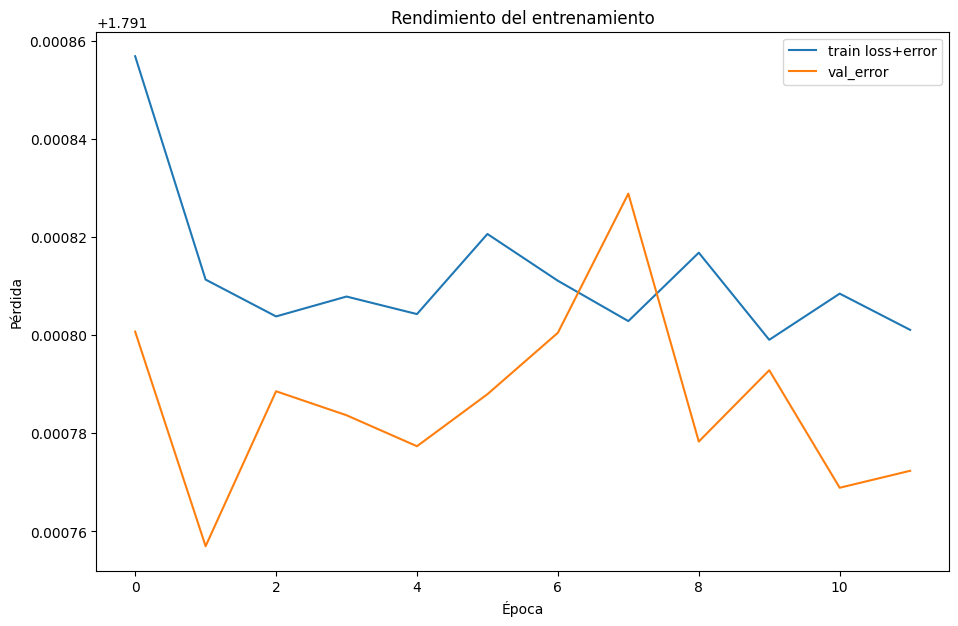

In [ ]:
# Show loss curves
plt.figure(figsize = (11, 7))
plt.title('Rendimiento del entrenamiento')
plt.plot(history.epoch, history.history['loss'], label = 'train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

Se hacen predicciones sobre las pruebas y se comparan con etiquetas reales.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_predict = model.predict(X_test)
y_predict_classes = np.argmax(y_predict, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_predict_classes))

1552/1552 [==============================] - 4s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8274
           1       0.00      0.00      0.00      8325
           2       0.00      0.00      0.00      8200
           3       0.17      1.00      0.29      8328
           4       0.00      0.00      0.00      8254
           5       0.00      0.00      0.00      8278

    accuracy                           0.17     49659
   macro avg       0.03      0.17      0.05     49659
weighted avg       0.03      0.17      0.05     49659



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Se calcula un reporte de clasificación. Esta tabla muestra métricas por clase como precisión, recall, f1-score para evaluar desempeño.

In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict, axis = 1)))

1552/1552 [==============================] - 5s 3ms/step
              precision    recall  f1-score   support

           0       0.49      0.84      0.62      8274
           1       0.55      0.27      0.36      8325
           2       0.50      0.23      0.32      8200
           3       0.50      0.31      0.38      8328
           4       0.43      0.65      0.51      8254
           5       0.83      0.98      0.90      8278

    accuracy                           0.55     49659
   macro avg       0.55      0.55      0.52     49659
weighted avg       0.55      0.55      0.52     49659



## **MATRIZ DE CONFUSIÓN**

Se grafica la matriz de confusión para el modelo clasificador previamente entrenado y evaluado. Esta matriz permite analizar en detalle el desempeño del modelo al mostrar la cantidad de casos por clase que fueron bien o mal clasificados.

49/49 [==============================] - 1s 30ms/step


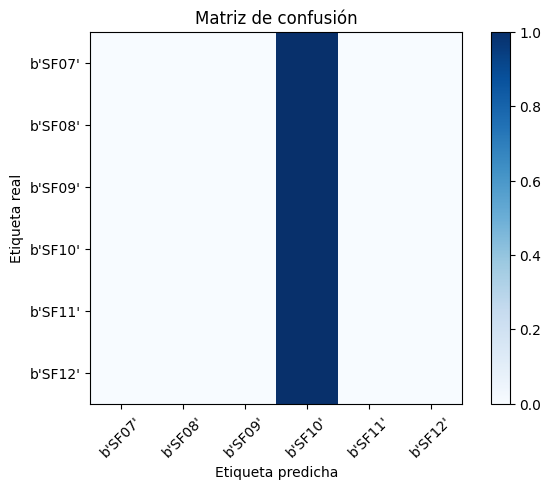

In [ ]:
def plot_confusion_matrix(cm, title='Matriz de confusión', cmap = plt.cm.Blues, labels = []):
#     plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
def confusion_matrix(model, classes, X_test, y_test):
    test_Y_hat = model.predict(X_test, batch_size = 1024)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for i in range(0, X_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plot_confusion_matrix(confnorm, labels = classes)

# GRAFICAR LA MATRIZ DE CONFUSION
confusion_matrix(model, classes, X_test, y_test)

(OPCIONAL) En caso de tener más niveles de SNR, se debe acomodar el siguiente snippet apuntando a los elementos de la matriz "temp_array". Esto permite evaluar si el desempeño del modelo se degrada para ciertos niveles de ruido.

In [ ]:
## Obtener la precisión de la prueba para diferentes SNRs
def getTestAccArray(model, lbl, X_test, y_test, test_idx):
    acc = []

    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[0])

    for snr in snr_label_array:
#         test_SNRs = map(lambda x: lbl[x][1], test_idx)
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]

        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])

        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1

        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, title="Matriz de confusión ConvNet (SNR=%d)"%(SNR_value))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Precisión general:", cor / (cor+ncor),"para SNR",snr)
#         acc[snr] = 1.0*cor/(cor+ncor)
        acc.append(1.0*cor/(cor+ncor))

    return acc

Se llama a la función previa, para obtener la precisión y la matriz de confusión del modelo según cada nivel de SNR.

6208/6208 [==============================] - 13s 2ms/step
Precisión general: 0.9064479102689315 para SNR b'38'


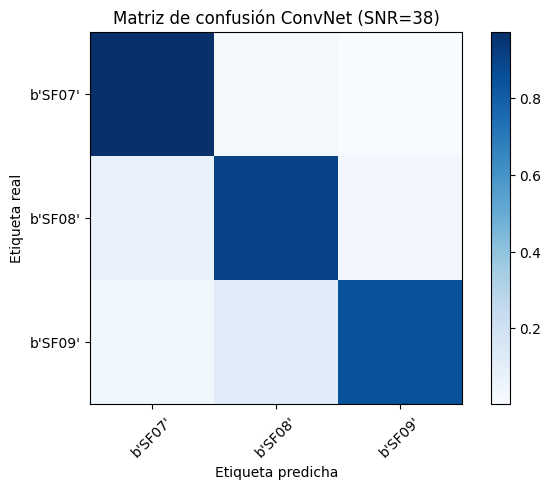

In [ ]:
acc = getTestAccArray(model, lbl, X_test, y_test, test_idx)

(OPCIONAL) Se grafica la gráfica de precisión del modelo en función de cada nivel de SNR (Si sólo se tiene un nivel, esta gráfico no es necesario).

Text(0.5, 1.0, 'Precisión vs SNR')

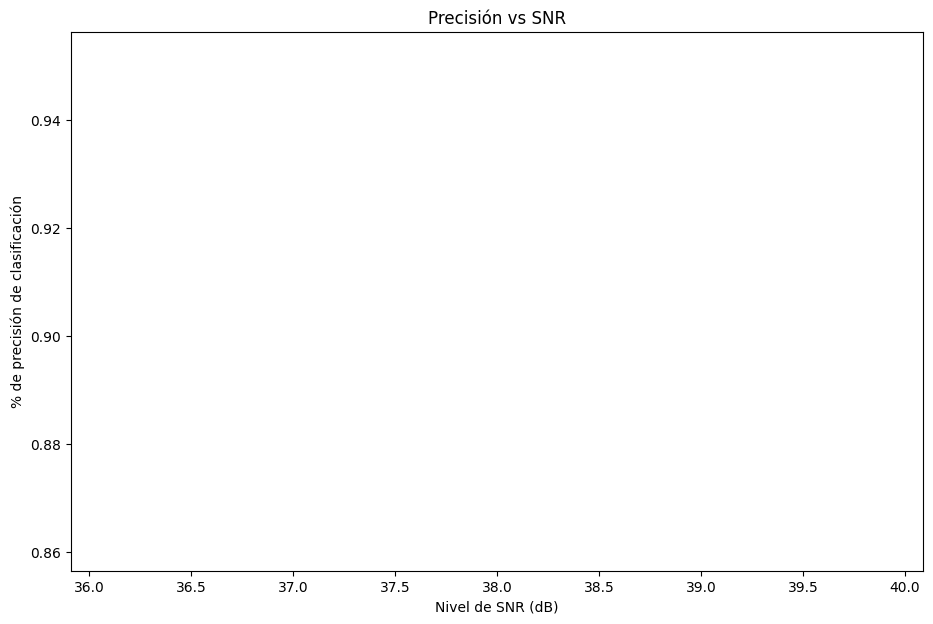

In [ ]:
# Plot accuracy curve
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc)
plt.xlabel("Nivel de SNR (dB)")
plt.ylabel("% de precisión de clasificación")
plt.title('Precisión vs SNR')